In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.append("/Users/maia/Projects/brownian-manifold/")
sys.path.append("/Users/maia/Projects/thesis-code/drift_fn_models")
# from brownian_manifold.manifold import Manifold
from brownian import brownian
from sklearn.metrics.pairwise import cosine_similarity
from numpy.fft import fft, ifft, fftshift
import scipy
from sklearn.decomposition import PCA


In [2]:
%matplotlib notebook

In [3]:
def cos_sim(a, b): 
#     return np.dot(a, b) / (np.sqrt(np.dot(a,a)) * np.sqrt(np.dot(b, b)))
    return cosine_similarity(a.reshape(1, -1), b.reshape(1, -1))

def estimate_step_similarity_over_time(steps, d_intervals, n_samples=100, euclidean=False):
    indices = list(range(len(steps) - d_intervals[-1]))
    interval_indices = list(range(len(d_intervals)))
    avg_d = np.zeros(len(d_intervals))
    min_d = np.zeros(len(d_intervals)) - 1
    max_d = np.zeros(len(d_intervals)) - 1
    vals = np.zeros((n_samples, len(d_intervals)))
    for i in range(n_samples):
        start_ind = np.random.choice(indices)

        for j in interval_indices:
            if euclidean: 
                d = np.linalg.norm(steps[start_ind] - steps[start_ind + d_intervals[j]])
            else: 
                d = cos_sim(steps[start_ind], steps[start_ind + d_intervals[j]])
            vals[i, j] = d
    #             avg_d[j] += d
    #             if d < min_d[j] or min_d[j] == -1:
    #                 min_d[j] = d
    #             if d > max_d[j] or max_d[j] == -1:
    #                 max_d[j] = d
    # return avg_d / n_samples, min_d, max_d
    avg = np.mean(vals, axis=0)
    stddev = np.std(vals, axis=0)
    mind = np.min(vals, axis=0)
    maxd = np.max(vals, axis=0)
    return avg, stddev, mind, maxd

def single_series_time_average(steps, d_intervals, euclidean=False, centered=False):
    indices = list(range(len(steps) - d_intervals[-1]))
    interval_indices = list(range(len(d_intervals)))
    vals = np.zeros((len(indices), len(d_intervals)))
    for k in indices:
        for j in interval_indices:
            if euclidean: 
                v = np.linalg.norm(steps[k] - steps[k + d_intervals[j]])
            else: 
                if centered and k > 0: 
                    origin_offset = steps[k - 1]
                else: 
                    origin_offset = 0
                reference_pt = steps[k] - origin_offset
                comparison_pt = steps[k + d_intervals[j]] - origin_offset
                v = cos_sim(reference_pt, comparison_pt)
            vals[k, j] = v
#     print(np.max(vals[1:50], axis=0))
#     print(np.max(vals[50:100], axis=0))
#     print(np.min(vals[1:50], axis=0))
#     print(np.min(vals[50:100], axis=0))
    avg = np.mean(vals[1:], axis=0)
    stddev = np.std(vals[1:], axis=0)
    return avg, stddev

def single_series_time_average_from_start(steps, d_intervals, start_pt=0, euclidean=False, centered=False):
    interval_indices = list(range(100))
    vals = np.zeros(len(interval_indices))
    k = start_pt 
    for j in interval_indices:
        if euclidean: 
            v = np.linalg.norm(steps[k] - steps[k + interval_indices[j]])
        else: 
            if centered and k > 0: 
                origin_offset = steps[k - 1]
            else: 
                origin_offset = 0
            reference_pt = steps[k] - origin_offset
            comparison_pt = steps[k + interval_indices[j]] - origin_offset
            v = cos_sim(reference_pt, comparison_pt)
        vals[j] = v
    return vals, np.zeros(vals.shape)

def multi_series_time_average(context_fun, d_intervals, n_samples, euclidean=False):
    vals = np.zeros((n_samples, len(d_intervals)))
    avg_avg = 0
    avg_stddev = 0
    for i in range(n_samples):
        context = context_fun()
        avg, stddev = centered_single_series_time_average(context, d_intervals, euclidean) # single_series_time_average(context, d_intervals, euclidean)
    return avg, stddev, mind, maxd

def bucketed_avg_similarity(steps, d_intervals, n_samples=100, euclidean=False):
    indices = list(range(len(steps) - d_intervals[-1]))
    interval_indices = list(range(len(d_intervals)))
    avg_d = np.zeros(len(d_intervals))
    min_d = np.zeros(len(d_intervals)) - 1
    max_d = np.zeros(len(d_intervals)) - 1
    vals = np.zeros((n_samples, len(d_intervals)))
    for i in range(n_samples):
        start_ind = np.random.choice(indices)

        for j in interval_indices:
            if euclidean: 
                d = np.linalg.norm(steps[start_ind] - steps[start_ind + d_intervals[j]])
            else: 
                d = cos_sim(steps[start_ind], steps[start_ind + d_intervals[j]])
            vals[i, j] = d
    #             avg_d[j] += d
    #             if d < min_d[j] or min_d[j] == -1:
    #                 min_d[j] = d
    #             if d > max_d[j] or max_d[j] == -1:
    #                 max_d[j] = d
    # return avg_d / n_samples, min_d, max_d
    avg = np.mean(vals, axis=0)
    stddev = np.std(vals, axis=0)
    mind = np.min(vals, axis=0)
    maxd = np.max(vals, axis=0)
    return avg, stddev, mind, maxd
    

def autocorrelation_of_intervals(steps, d_intervals, n_samples=100, euclidean=False):
    indices = list(range(len(steps) - d_intervals[-1]))
    interval_indices = list(range(len(d_intervals)))
    avg_d = np.zeros(len(d_intervals))
    min_d = np.zeros(len(d_intervals)) - 1
    max_d = np.zeros(len(d_intervals)) - 1
    vals = np.zeros((n_samples, len(d_intervals)))
    min_end = len(steps) - d_intervals[-1]
    for j in interval_indices:
        int_end = min_end + d_intervals[j]
        d_intervals[j]
        d = autocorr(steps[:int_end], d_intervals[j])
        # vals[:, j] = d
    avg = np.mean(vals, axis=0)
    stddev = np.std(vals, axis=0)
    mind = np.min(vals, axis=0)
    maxd = np.max(vals, axis=0)
    return avg, stddev, mind, maxd
    

In [4]:

def iid_noise(n_steps=20, dim=10, var=0.0, mean=1, beta=0.0, multi_steps=0):
    ctxt = np.zeros((n_steps, dim))
    ctxt[0] = np.random.random(dim)
    for i in range(1, n_steps):
        noise = np.random.normal(mean, var, size=dim)
        ctxt[i] = ctxt[i - 1] + noise
    if mean == 0:
        stem = "walk_diffusion_"
    else:
        stem = "walk_drift_"
    fn_name = stem + "d=" + str(dim) + "_m=" + str(mean) + "_v=" + str(var)
    return ctxt, fn_name


def path_integration(n_steps=10, var=0.3, mean=0.0, dim=10, beta=0.3, multi_steps=1, normed=False):
    ctxt = np.zeros((n_steps, dim))
    #ctxt[0] = np.random.random(dim) * var + mean
    for i in range(1, n_steps):
        prev_c = ctxt[i - 1]
        for j in range(multi_steps):
            stim = np.random.normal(mean, var, size=(dim))
            stim = np.expand_dims(stim, axis=0)
            prev_c = (1 - beta) * prev_c + beta * stim
            # print(np.linalg.norm(prev_c))
            if normed:
                prev_c = prev_c / np.linalg.norm(prev_c)
        ctxt[i] = prev_c
    if mean == 0:
        stem = "path_integration_diffusion_"
    else:
        stem = "path_integration_drift_"
    fn_name = stem + "d=" + str(dim) + "_m=" + str(mean) + "_v=" + str(var) + "_b=" + str(beta)
    return ctxt, fn_name

def n_sphere(n_steps=20, dim=10, var=0.25, mean=0.25, beta=0.0):
    ros = np.random.random(dim - 1)
    # ros = np.zeros(dim - 1)
    slen = n_steps
    ctxt = np.zeros((slen, dim))
    for i in range(slen):
        noise = np.random.normal(mean, var, size=(dim - 1))
        # print(noise)
        ros += noise
        ct = np.zeros(dim)
        ct[0] = np.cos(ros[0])
        for j in range(dim - 2):
            amt = np.product([np.sin(ros[k]) for k in range(j + 1)])
            amt *= np.cos(ros[j + 1])
            ct[j + 1] = amt
        ct[dim - 1] = np.product([np.sin(ros[j]) for j in range(dim - 1)])
        ctxt[i] = ct
    if mean == 0:
        stem = "spherical_diffusion_"
    else:
        stem = "spherical_drift_"
    fn_name = stem + "d=" + str(dim) + "_m=" + str(mean) + "_v=" + str(var)
    return ctxt, fn_name

def fast_n_sphere(n_steps=20, dim=10, var=0.25, mean=0.25, beta=0.0):
    ros = np.zeros(dim - 1)
    slen = n_steps
    ctxt = np.zeros((slen, dim))
    for i in range(slen):
        noise = np.random.normal(mean, var, size=(dim - 1))
        ros += noise
        ct = np.zeros(dim)
        prod = 1
        for j in range(dim - 1):
            amt = prod * np.cos(ros[j])
            ct[j] = amt
            prod *= np.sin(ros[j])
        ct[dim - 1] = prod
        ctxt[i] = ct
    if mean == 0:
        stem = "fast_spherical_diffusion_"
    else:
        stem = "fast_spherical_drift_"
    fn_name = stem + "d=" + str(dim) + "_m=" + str(mean) + "_v=" + str(var)
    return ctxt, fn_name

def new_n_sphere(n_steps=20, dim=10, var=0.25, mean=0.25, beta=0.0):
    ros = np.zeros(dim - 1)
    slen = n_steps
    ctxt = np.zeros((slen, dim))
    for i in range(slen):
        noise = np.random.normal(mean, var, size=(dim - 1))
        ros += noise
        ct = np.zeros(dim)
        ct[0] = np.cos(ros[0])
        prod = np.product([np.sin(ros[k]) for k in range(1, dim - 1)])
        n_prod = prod
        for j in range(dim - 2):
            n_prod /= np.sin(ros[j + 1])
            amt = n_prod * np.cos(ros[j + 1])
            ct[j + 1] = amt
        ct[dim - 1] = prod
        ctxt[i] = ct
    if mean == 0:
        stem = "new_spherical_diffusion_"
    else:
        stem = "new_spherical_drift_"
    fn_name = stem + "d=" + str(dim) + "_m=" + str(mean) + "_v=" + str(var)
    return ctxt, fn_name


def new_multiscale_n_sphere(n_steps=20, dim=10, var=0.25, mean=0.25, beta=0.0):
    ros = np.zeros(dim - 1)
    slen = n_steps
    ctxt = np.zeros((slen, dim))
    ms = np.linspace(0, mean, num=dim)
    ms = ms[1:]
    vs = np.zeros(dim - 1)
    for i in range(slen):
        noise = np.random.normal(ms, vs, size=(dim - 1))
        ros += noise
        ct = np.zeros(dim)
        ct[0] = np.cos(ros[0])
        prod = np.product([np.sin(ros[k]) for k in range(1, dim - 1)])
        n_prod = prod
        for j in range(dim - 2):
            n_prod /= np.sin(ros[j + 1])
            amt = n_prod * np.cos(ros[j + 1])
            ct[j + 1] = amt
        ct[dim - 1] = prod
        ctxt[i] = ct
    if mean == 0:
        stem = "new_multiscale_spherical_diffusion_"
    else:
        stem = "new_multiscale_spherical_drift_"
    fn_name = stem + "d=" + str(dim) + "_m=" + str(mean) + "_v=" + str(var)
    return ctxt, fn_name

def multiscale_n_sphere(n_steps=20, dim=10, var=0.25, mean=0.25, beta=0.0):
    ros = np.zeros(dim - 1)
    # ros = np.zeros(dim - 1)
    slen = n_steps
    ctxt = np.zeros((slen, dim))
    ms = np.linspace(0, mean, num=dim)
    ms = ms[1:]
    # should this be 0 variance? Or variance that increases along w mean of dimension?
    vs = np.zeros(dim - 1)
    for i in range(slen):
        noise = np.random.normal(ms, vs, size=(dim - 1))
        ros += noise
        ct = np.zeros(dim)
        prod = 1
        for j in range(dim - 1):
            amt = prod * np.cos(ros[j])
            ct[j] = amt
            prod *= np.sin(ros[j])
        ct[dim - 1] = prod
        ctxt[i] = ct
    if mean == 0:
        stem = "multiscale_spherical_diffusion_"
    else:
        stem = "multiscale_spherical_drift_"
    fn_name = stem + "d=" + str(dim) + "_m=" + str(mean) + "_v=" + str(var)
    return ctxt, fn_name

In [5]:
euclidean = False
short_int = True
if short_int: 
    d_intervals = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
else: 
    d_intervals = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    d_intervals = list(range(100))
prefix = "Autocorr using euclidean dist b/t intervals, dim=" if euclidean else "Autocorr using cosine similarity, "
n_samples=1

In [6]:
context_fn = fast_n_sphere

##### stim_d = 100
var = 0.05
mean = 0.25
beta = 0.0
multi_step = 1
dim = 25
start_pt = 0

ctxt, fn_name = context_fn(n_steps=10, var=var, mean=mean, dim=dim, beta=beta)

param_title_string = "autocorrelation, " + fn_name


<IPython.core.display.Javascript object>


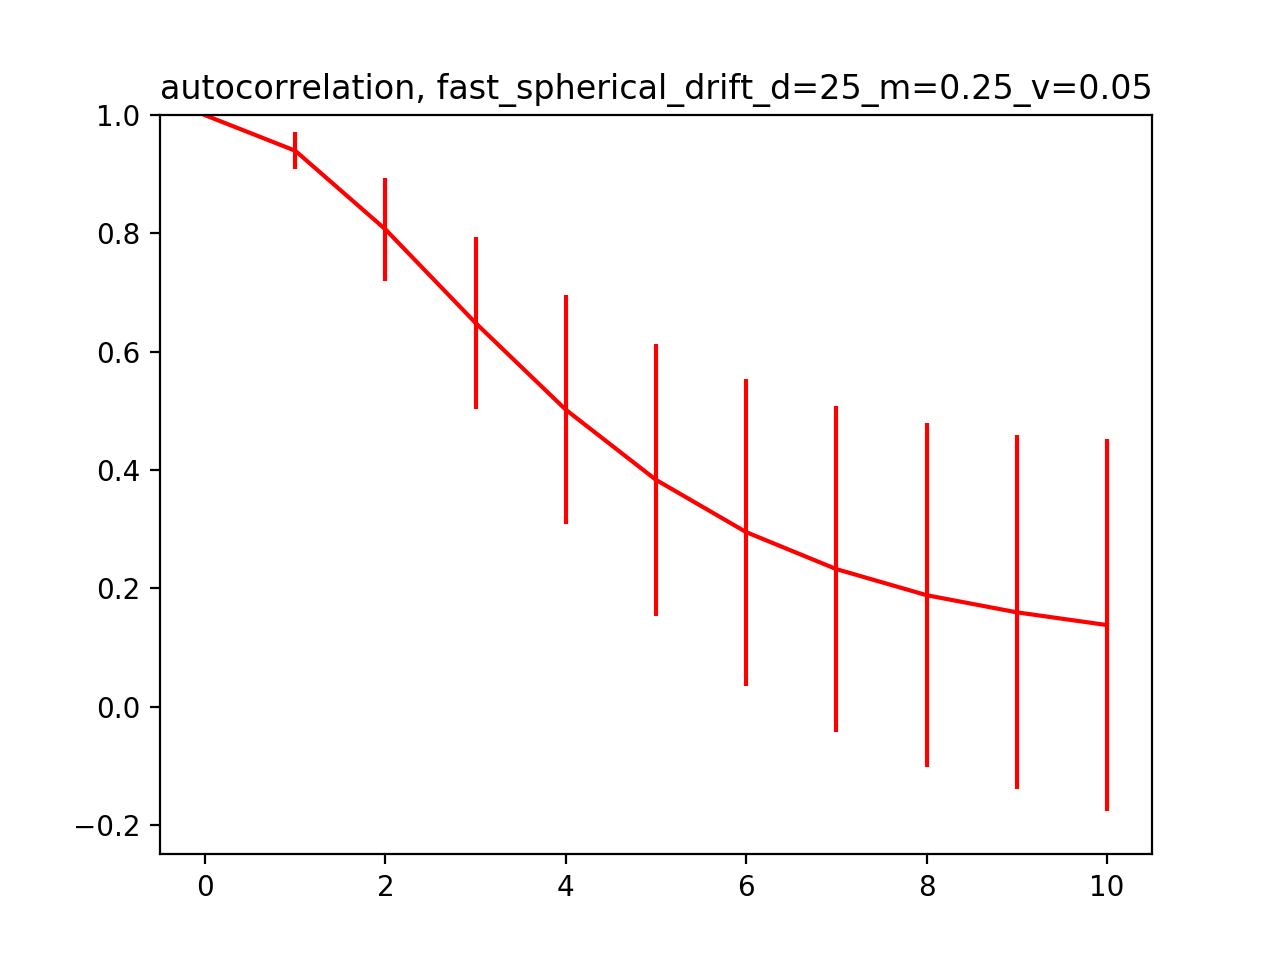

In [309]:
# CHANGE BACK TO 5000
steps = context_fn(n_steps=1000, var=var, mean=mean, dim=dim, beta=beta)[0]
# avg_d, std_d = single_series_time_average_from_start(steps, d_intervals, start_pt=start_pt, euclidean=euclidean, centered=True)
avg_d, std_d = single_series_time_average(steps, d_intervals, euclidean=euclidean, centered=True)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title(param_title_string)
ax.errorbar(d_intervals, avg_d, yerr=std_d, color="red")
# ax.plot(d_intervals, min_d, color="blue", label="min distance")
# ax.plot(d_intervals, max_d, color="green", label="max distance")
ax.set_ylim(-0.25, 1.0)
# ax.set_xscale("log")
fig.savefig("/Users/maia/Projects/thesis-code/Figures/autocorrelations/" + fn_name + "eudc=" + str(euclidean) + "_sint=" + str(short_int) + ".png")



<IPython.core.display.Javascript object>


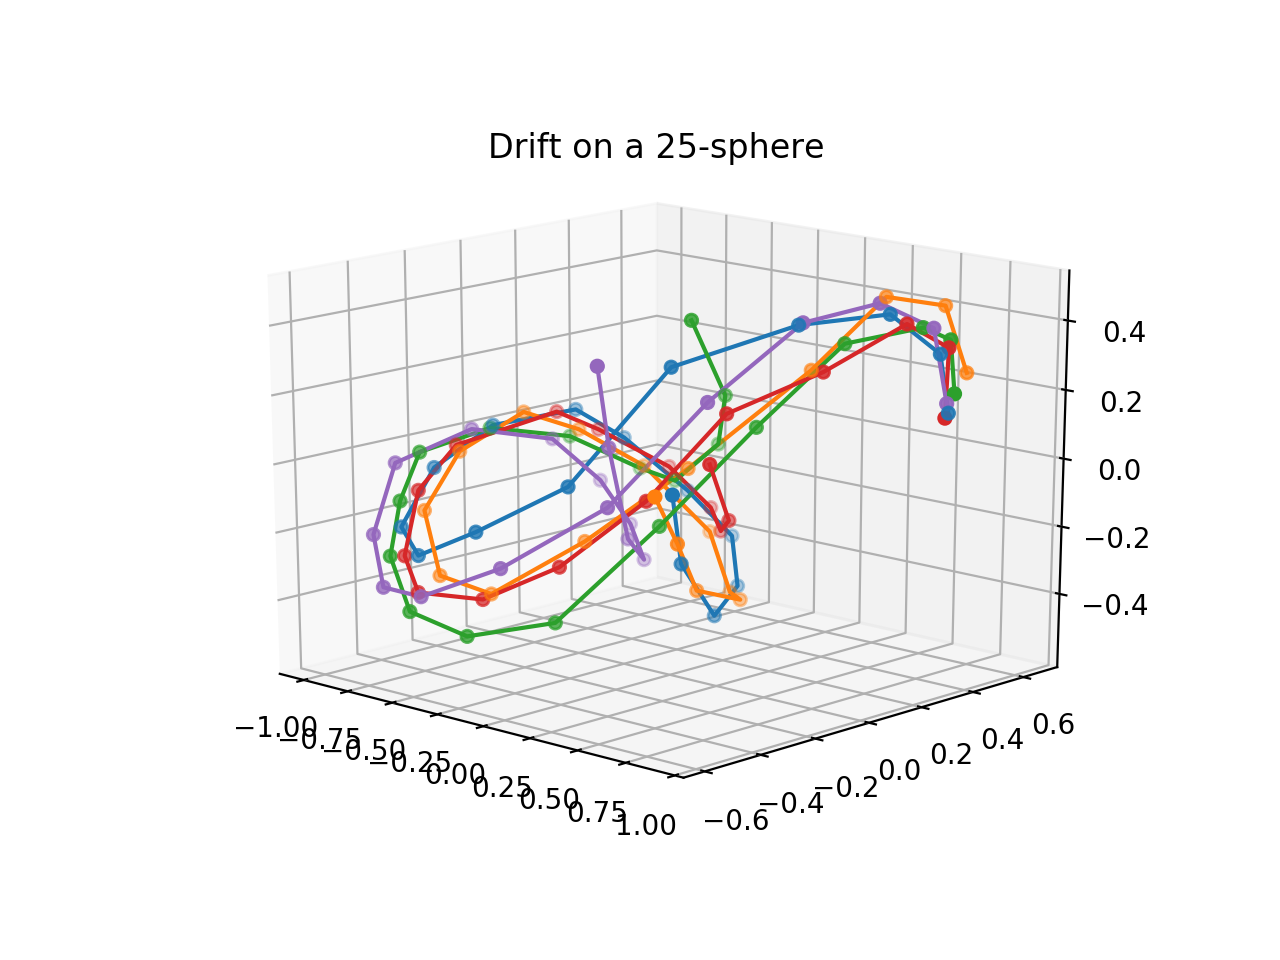

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
vis_title = fn_name
ax.set_title("Drift on a 25-sphere")
for i in range(5):
    ctxt = context_fn(n_steps=20, var=var, mean=mean, dim=25, beta=beta)[0]
    ax.scatter(ctxt[1:, 0], ctxt[1:, 1], ctxt[1:, 2])
    ax.plot(ctxt[1:, 0], ctxt[1:, 1], ctxt[1:, 2])
fig.savefig("/Users/maia/Projects/thesis-code/Figures/posterfigs/25-" + fn_name + ".png")